In [1]:
!pip install sentence_transformers==0.3.8 
!pip install umap-learn==0.4.6 

     |████████████████████████████████| 71kB 8.2MB/s 
     |████████████████████████████████| 1.1MB 24.9MB/s 
     |████████████████████████████████| 3.0MB 32.1MB/s 
     |████████████████████████████████| 890kB 61.7MB/s 
     |████████████████████████████████| 1.2MB 53.1MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.8-cp36-none-any.whl size=101996 sha256=f83a01b82e92408227860dd285d863938eb457f0777af6e1a81b720819b6fb97
  Stored in directory: /root/.cache/pip/wheels/27/ec/b3/d12cc8e4daf77846db6543033d3a5642f204c0320b15945647
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=58fc81971c080fbb59366c96906e74f65f9dbb6851db094a4612ddae7c1b4aae
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses
     |████████████████████████████████| 71kB 8.5MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.4.6-c

In [2]:
import numpy as np
import pandas as pd

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from string import punctuation

from collections import Counter
from collections import OrderedDict

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture

from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
PATH = "./drive/My Drive/Colab Notebooks/IRTG/Smart_contracts_paper/USC/SC-literature-research/"

In [4]:
# data loaded on 13. October 2020
df = pd.read_csv(f"{PATH}scopus/scopus.csv")
df = df[['Authors', 'Title', 'Year', 'Cited by', 'Abstract', 'Author Keywords']]

# correct year (conference 2019)
df.loc[df.Year<2016, 'Year'] = 2019

In [5]:
df['Author Keywords'] = df['Author Keywords'].str.lower()

#remove ethereum, smart contract, smart contracts, blockchain
df['Author Keywords'] = df['Author Keywords'].str.replace('blockchain;?', '')
df['Author Keywords'] = df['Author Keywords'].str.replace('smart contracts;?', '')
df['Author Keywords'] = df['Author Keywords'].str.replace('smart contract;?', '')
df['Author Keywords'] = df['Author Keywords'].str.replace('ethereum;?', '').str.strip()
df['Author Keywords'] = df['Author Keywords'].str.rstrip(';')

df['keywords_list']   = df['Author Keywords'].str.split(';')
df.rename(columns={'Author Keywords': 'keywords'}, inplace=True)
df.keywords.fillna('empty', inplace=True)

Code based on the blogpost https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6


In [6]:
model = SentenceTransformer('bert-base-nli-mean-tokens')
embeddings = model.encode(df.Abstract, show_progress_bar=True)

100%|██████████| 405M/405M [00:17<00:00, 23.2MB/s]


In [7]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine', random_state=42).fit_transform(embeddings)

In [8]:
km_silhouette = []
km_db = []
n_clusters = [*range(3,50)]

In [9]:
for i in n_clusters:
    cluster = KMeans(n_clusters=i,          
                    random_state=42).fit(umap_embeddings)
    
    preds = cluster.predict(umap_embeddings)
    
    s_score = silhouette_score(umap_embeddings, preds)
    db_score = davies_bouldin_score(umap_embeddings, preds)
    km_silhouette.append(s_score)
    km_db.append(db_score)

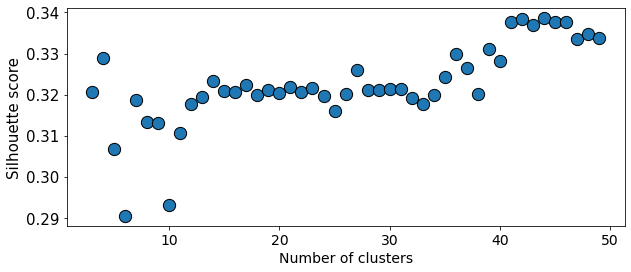

In [10]:
plt.figure(figsize=(10,4))
#plt.title("The Silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in n_clusters], y=km_silhouette, s=150, edgecolor='k')
plt.xlabel("Number of clusters", fontsize=14)
plt.ylabel("Silhouette score", fontsize=15)
plt.xticks([10, 20, 30, 40, 50], fontsize=14)
plt.yticks(fontsize=15)
#plt.show()
plt.savefig(f"{PATH}/images/silhouette_square.png", transparent=True)

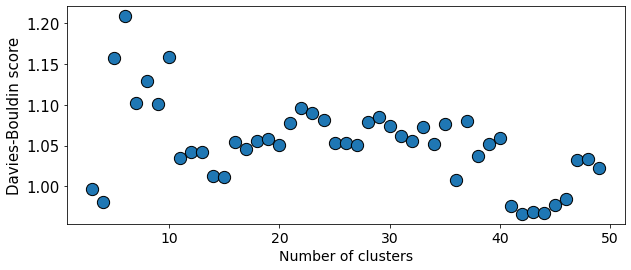

In [11]:
plt.figure(figsize=(10,4))
#plt.title("The Davies-Bouldin score \nfor determining number of clusters\n", fontsize=16)
plt.scatter(x=[i for i in n_clusters], y=km_db, s=150, edgecolor='k')
plt.xlabel("Number of clusters", fontsize=14)
plt.ylabel("Davies-Bouldin score", fontsize=15)
plt.xticks([10, 20, 30, 40, 50], fontsize=14)
plt.yticks(fontsize=15)
#plt.show()
plt.savefig(f"{PATH}/images/davies_square.png", transparent=True)

In [12]:
cluster = KMeans(n_clusters=10,          
                    random_state=42).fit(umap_embeddings)

In [13]:
color_map = {0: 'tab:blue',
             1: 'tab:orange',
             2: 'tab:green',
             3: 'tab:red',
             4: 'tab:purple',
             5: 'tab:brown',
             6: 'tab:pink',
             7: 'tab:gray',
             8: 'tab:olive',
             9: 'tab:cyan'} 

7     105
11     97
1      95
6      77
0      76
8      72
2      66
3      52
5      49
4      44
13     36
12     29
10     26
9      15

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


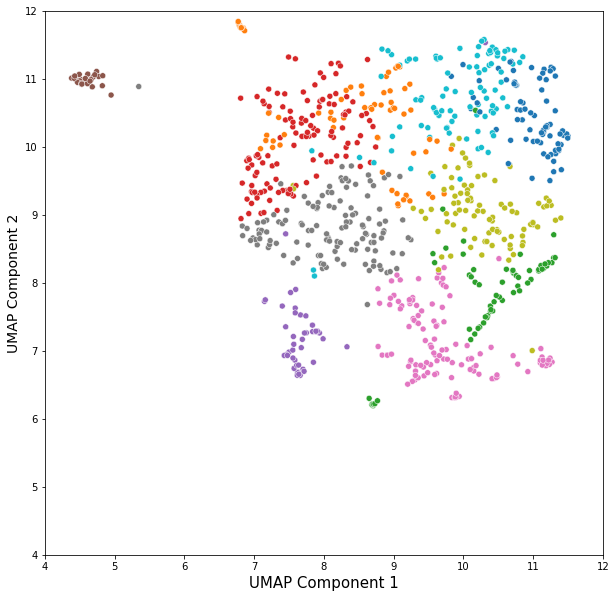

In [15]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(result.x, result.y, c=result.labels.map(color_map))
plt.xlabel("UMAP Component 1", fontsize=15)
plt.ylabel("UMAP Component 2", fontsize=14)
plt.xlim((4, 12))
plt.ylim((4, 12))
plt.savefig(f"{PATH}/images/scatter_research_tsquare_lim.png", transparent=True)

In [ ]:
result['labels'].value_counts()

7    125
3    124
6    119
9     94
8     91
0     76
1     72
2     66
4     44
5     28
Name: labels, dtype: int64

In [ ]:
import os
if not os.path.exists(PATH + 'output'):
  os.mkdir(PATH + 'output')
  result.to_csv(PATH + 'output/umap_coefs_labelled.csv', index=False)

In [ ]:
docs_df = pd.DataFrame(df, columns=["Abstract"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Abstract': ' '.join})
docs_per_topic.to_csv(PATH + 'output/docs_per_topic.csv', index=False)

In [ ]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Abstract.values, m=len(df))

In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10)

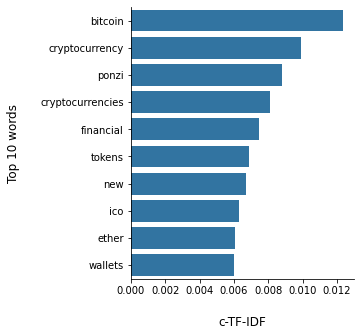

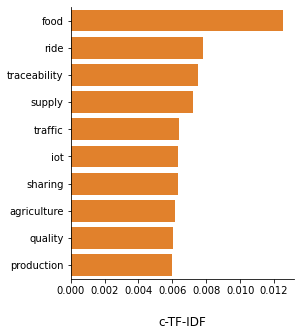

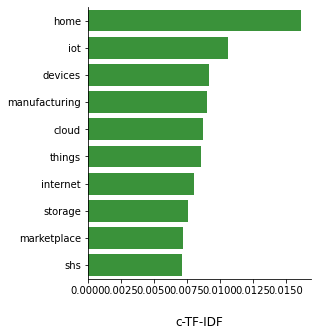

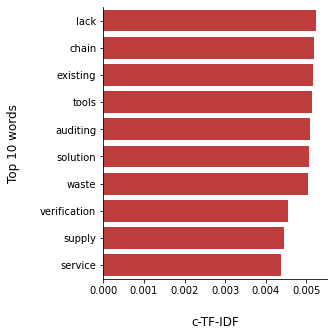

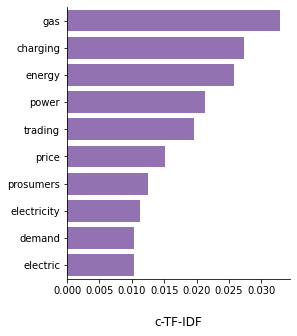

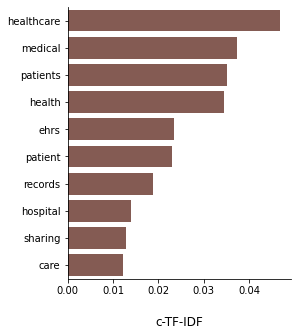

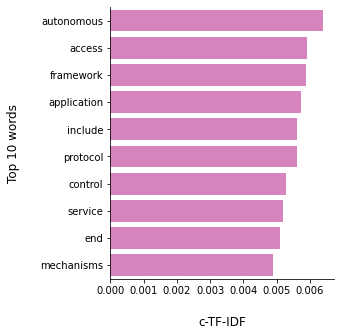

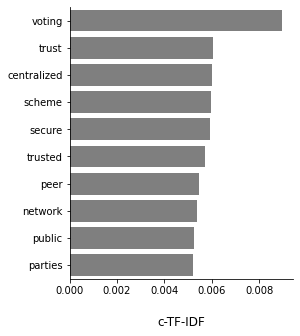

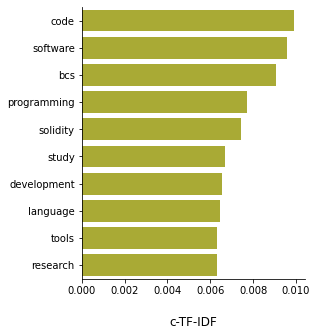

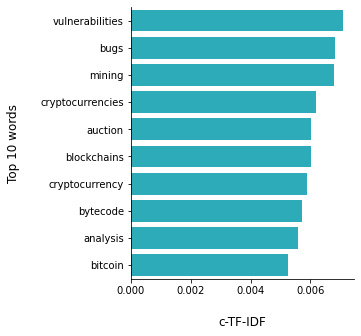

In [ ]:
for i in range(10):
  temp_df = pd.DataFrame(top_n_words[i])
  temp_df.sort_values(1, ascending=True, inplace=True)
  fig, ax = plt.subplots(figsize=(4, 5))
  sns_plot = sns.barplot(x=1, y=0, data=temp_df, color=color_map[i], ax=ax)
  sns.despine()

  # Set y-axis label
  if i in [0, 3, 6, 9, 12]: 
    ax.set_ylabel("Top 10 words", labelpad=20, size=12)
  else:
    ax.set_ylabel("", labelpad=20, size=12)
  ax.set_ylim(-0.5, 9.5)
  ax.set_xlabel("c-TF-IDF", labelpad=20, size=12)
  sns_plot.figure.savefig(f"{PATH}/images/Topic_{i}_t.png", bbox_inches = "tight", transparent=True)

In [ ]:
fig= plt.figure()
plt.savefig(f"{PATH}/images/empty.png", bbox_inches = "tight")

<Figure size 432x288 with 0 Axes>